<center><font size="+2"><b><u> Peptide structure analysis </u></b></font></center>
<br></br>
<center> This script will calclulate dihedral angles, circular variance and create ramachandran plots</center>

<b> To Do: </b>
<ul>
Ammend script so it does not matter where protein appears in trajectory</ul>


By Philip Ferguson

In [1]:
import MDAnalysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from MDAnalysis.analysis.dihedrals import Dihedral


In [2]:
##################FILL OUT BELOW BEFORE STARTING#############
##gromacs configuration file###
gro_file = 'fullsys.gro'
##compressed trajectory file###
trajectory_file = 'final.xtc'
u = MDAnalysis.Universe('%s'%gro_file, '%s'%trajectory_file)
##### Sim start and sim end time in ns
start = 0 
end = 200


In [3]:
################################# INSERT INFO FOR PEPTIDE1 ##########################################
peptide = dict()
#### Single letter sequence #####
peptide['sequence'] = 'FVQWFSKFLGRIL'
#### Peptide name #####
peptide['peptide_name'] = 'Temporin L'
#### Number of peptides #####
peptide['pepnum'] = 8
### DO NOT EDIT ###
peptide['resnum'] = len(peptide['sequence'])
peptide['restot'] = peptide['pepnum']*peptide['resnum']
peptide['starting_resid'] = 1

In [4]:


#create dictionary of amino acids 
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HSP': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
#invert to permit single letter to be entered
inv_map = {v: k for k, v in d.items()}
#generate 3 letter code with residue position
def single_three(sequence,resnum):
    single = (list(sequence)) 
    Aminos=[]
    for i in range(0,(resnum)):
        value = single[i]
        Aminos.append((str(i+1))+inv_map[value])
    return Aminos
peptide['Aminos'] = single_three(peptide['sequence'],peptide['resnum'])

<center><font size="+2"><b><u> Dihedral angles and Circular variance </u></b></font></center>
<br></br>
<center> The following class will calculate all that is needed for circular variance and dihedral angle per residues. The average dihedral angle is calculated by taking the cicular average for each residue accross each peptide and the full duration of the simulation. The circular variance is calculated as the spread of angles accross all peptides and timesteps for each residue</center>

<br></br>
<center> For the order over time plots the average and cirular variance is no longer taken accross the whole simulation and is averaged per residue, as a function of time</center>

<b> To Do: </b>
<ul>
    <li>
    Consider ways to run dihedral calculation only once to speed up and reduce computational expense
    </li>
</ul>



By Philip Ferguson


In [5]:
class Dihedral_angles():
    from MDAnalysis.analysis.dihedrals import Dihedral
    ##loop to calculate angles, turn into function to replace peptide range and residue number 
    def angle(peptide,dihedral):
        """ Calculates the dihedral angles per residue for each peptide"""
        peptides = []
        angles=[]
        start_pep = int((peptide['starting_resid']-1)/peptide['resnum'])
        end_pep = int(start_pep + peptide['pepnum'])
        if dihedral == "phi":
            for i in range(start_pep,end_pep):
                peptides.append([res.phi_selection() for res 
                                 in u.residues[(i*peptide['resnum'])+1:((i+1)*peptide['resnum'])-1]])
            for peptide in peptides:
                angles.append(Dihedral(peptide).run(step=50).angles)
            return angles
        else:
            for i in range(start_pep,end_pep):
                peptides.append([res.psi_selection() for res 
                                 in u.residues[(i*peptide['resnum'])+1:((i+1)*peptide['resnum'])-1]])
            for peptide in peptides:
                angles.append(Dihedral(peptide).run(step=50).angles)
            return angles
        
    def mean_angle(peptide,dihedral):
        """ Calculates the of the dihedral angles using above function"""
        data = np.array(Dihedral_angles.angle(peptide,dihedral))
        m,n,r = np.shape(data)
        out_arr_phi = np.delete(np.column_stack((np.repeat(np.arange(m),n),data.reshape(m*n,-1))),0,axis=1) 
        return out_arr_phi
    def circularAverage(peptide,dihedral,mean="yes",rama="no",axis=0): 
        """ Returns average and standard deviation of a set of angles,
            taking into account that angles are a circular quantity.
            Note that the circular variance is a value between 0 and 1, and
            is not given in degrees.
        """
        if mean == "yes":
            in1 = Dihedral_angles.mean_angle(peptide,dihedral)
        elif rama == "yes":
            in1 = peptide
        else:
            in1 = Dihedral_angles.angle(peptide,dihedral)
        data = np.radians(in1)
        costheta, sintheta = np.cos(data), np.sin(data)
        xmean, ymean = np.mean(costheta, axis=axis), np.mean(sintheta, axis=axis)
        mean = np.arctan2(ymean, xmean)
        Rsq = np.sum(costheta, axis=axis)**2 + np.sum(sintheta, axis=axis)**2
        variance = 1 - (np.sqrt(Rsq) / costheta.shape[axis])
        return np.degrees(mean), variance

###functions to do:
####Could phi and psi function be combined??

In [6]:
#Run functions for the two peptides
peptide['phi_PR'] = Dihedral_angles.circularAverage(peptide,"phi")
peptide['psi_PR'] = Dihedral_angles.circularAverage(peptide,"psi")


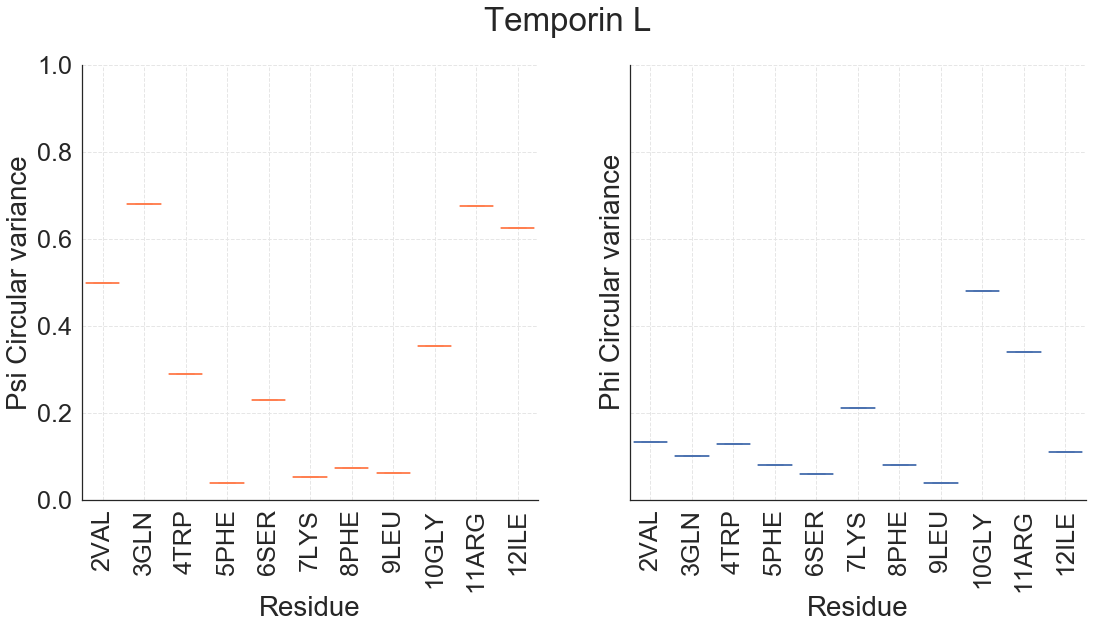

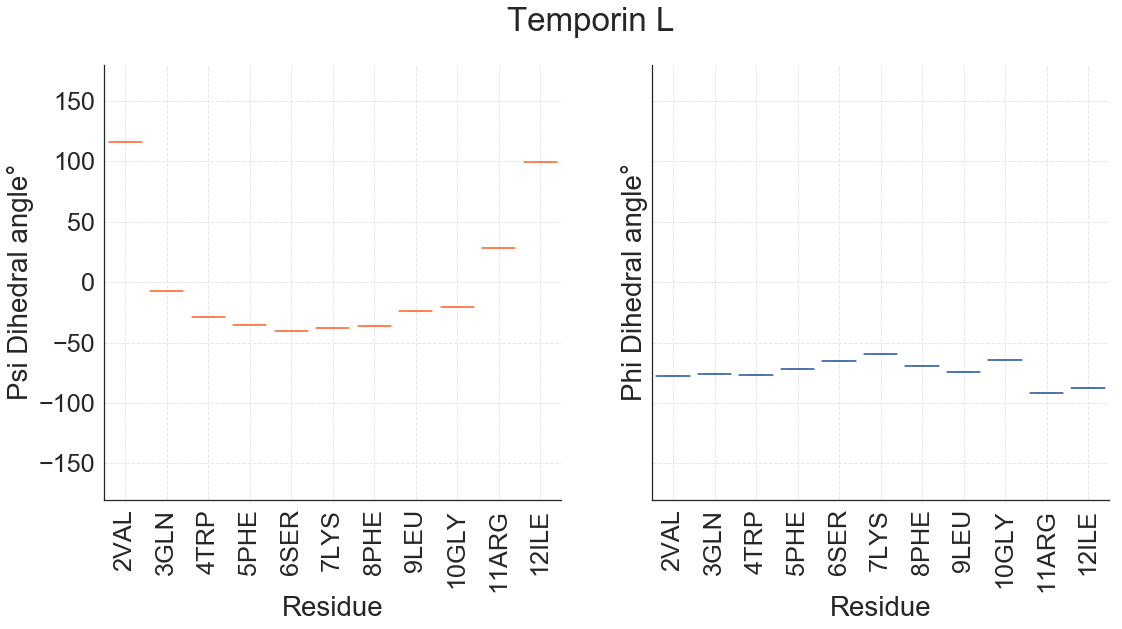

In [7]:
###plots circular variance as a function of residue. 
def plot_per_res(peptide,plot_type):
    degree_sign= u'\N{DEGREE SIGN}'
    ##select plot type as integer to slice
    if plot_type == "Circular variance":
        inny = 1
        plot_label = "%s"%plot_type
    else:
        inny = 0
        plot_label = "%s"%plot_type + "%s"%degree_sign
    #Create dataframes for plotting - Could not using pandas speed this up ?
    df_variance_phi = pd.DataFrame(peptide['phi_PR'][inny],columns=["%s"%plot_type])
    df_variance_phi['Residue'] = peptide['Aminos'][1:-1]
    header= "%s"%plot_type
    df_variance_psi = pd.DataFrame(peptide['psi_PR'][inny],columns=["%s"%plot_type])
    df_variance_psi['Residue'] = peptide['Aminos'][1:-1]

    #Start plotting, create two seaborn subplots
    sns.set(font_scale=2.3,style="white")
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.boxplot(data=df_variance_psi,y='%s'%plot_type, x='Residue',palette="Blues",ax=ax1)
    sns.boxplot(data=df_variance_phi,y='%s'%plot_type, x='Residue',palette="Reds",ax=ax2)
    sns.despine()

    ##ax1 is psi and ax2 is phi
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_xlabel('Residue')
    ax1.set_ylabel('Psi %s'%plot_label)
    ax2.tick_params(axis='x', labelrotation=90)
    ax2.set_xlabel('Residue')
    ax2.set_ylabel('Phi %s'%plot_label)
    ax1.set_axisbelow(True)
    ax2.set_axisbelow(True)
    ax2.grid(b=True, which='both', color='0.9', linestyle='--')
    ax1.grid(b=True, which='both', color='0.9', linestyle='--')

    ##Set up different colors
    plt.setp(ax1.artists, edgecolor = 'coral', facecolor='coral')
    plt.setp(ax1.lines, color='coral')
    plt.setp(ax2.artists, edgecolor = 'b', facecolor='w')
    plt.setp(ax2.lines, color='b')
    
    ##change y limits
    if plot_type == "Circular variance":
        plt.ylim(0,1)
    else:
        plt.ylim(-180,180)

    ###set figure size - this can be changed
    fig.set_size_inches(18, 8)
    filename = "%s"%plot_type + "%s"%peptide['peptide_name']
    plt.suptitle ('%s'%peptide['peptide_name'])
    plt.savefig('%s.png'%filename, dpi=300, bbox_inches="tight")
    
    
plot_per_res(peptide,plot_type="Circular variance")
plot_per_res(peptide,plot_type="Dihedral angle")

In [8]:
peptide['phi_time'] = Dihedral_angles.circularAverage(peptide,"phi",mean="no")
peptide['psi_time'] = Dihedral_angles.circularAverage(peptide,"psi",mean="no")


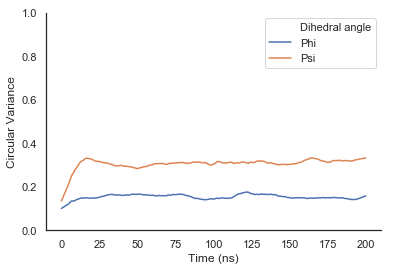

In [9]:
from scipy.signal import savgol_filter
def plot_cv_oot(peptide): 
    
    degree_sign= u'\N{DEGREE SIGN}'

    variance_phi= peptide['phi_time'][1]
    variance_psi= peptide['psi_time'][1]

    df_1 = pd.DataFrame(variance_phi)
    df_1['Dihedral angle'] = "Phi"
    df_1['Mean'] = df_1.mean(axis=1)
    df_1['Mean'] = savgol_filter(df_1['Mean'],11,1)

    df_2 = pd.DataFrame(variance_psi)
    df_2['Dihedral angle'] = "Psi"
    df_2['Mean'] = df_2.mean(axis=1)
    df_2['Mean'] = savgol_filter(df_2['Mean'],11,1)

    df_variance_oot = pd.concat([df_1,df_2])
    df_variance_oot = df_variance_oot[['Mean','Dihedral angle']]
    df_variance_oot = df_variance_oot.reset_index()


    ##plot circular variange over time for both dihedral angles
    sns.set(font_scale=1,style="white")
    sns.lineplot(data=df_variance_oot,y='Mean',x='index',hue='Dihedral angle')
    plt.xlabel("Time (ns)")
    plt.ylabel("Circular Variance")
    sns.despine()
    plt.xlabel("Time (ns)")
    plt.ylim(0,1)
    plt.ylabel("Circular Variance")
    plt.savefig('Circular_varince_OOT_%s.png'%peptide['peptide_name'], dpi=300, bbox_inches="tight")
plot_cv_oot(peptide)

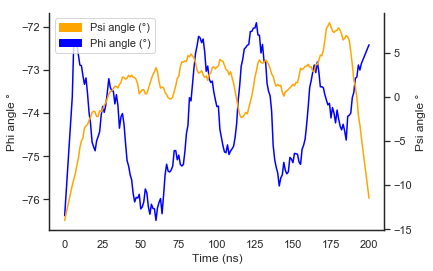

In [10]:
###calculate average dihedral angles over time
##The values will of course differ abnd probably be lower than the circular variance above
def plot_dihedrals_oot(peptide): 
    from scipy.signal import savgol_filter
    
    degree_sign= u'\N{DEGREE SIGN}'

    
    dihedral_phi=peptide['phi_time'][0]
    dihedral_psi=peptide['psi_time'][0]

    df_1 = pd.DataFrame(dihedral_phi)
    df_1['Dihedral angle'] = "Phi"
    df_1['Mean'] = df_1.mean(axis=1)
    df_1['Mean'] = savgol_filter(df_1['Mean'],11,1)

    df_2 = pd.DataFrame(dihedral_psi)
    df_2['Dihedral angle'] = "Psi"
    df_2['Mean'] = df_2.mean(axis=1)
    df_2['Mean'] = savgol_filter(df_2['Mean'],11,1)

    df_dihedral_oot = pd.concat([df_1,df_2])
    df_dihedral_oot = df_dihedral_oot[['Mean','Dihedral angle']]
    df_dihedral_oot = df_dihedral_oot.reset_index()


    import matplotlib.patches as mpatches
    ##plot circular variange over time for both dihedral angles
    ##plot psi on same plot with different axis
    ax = sns.lineplot(data=df_dihedral_oot[df_dihedral_oot['Dihedral angle'].str.contains('Phi')],
                                           y='Mean',x='index',color="Blue")
    ax2 = plt.twinx()
    ax2 = sns.lineplot(data=df_dihedral_oot[df_dihedral_oot['Dihedral angle'].str.contains('Psi')],
                      y='Mean',x='index',color="Orange")
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    ##label plots accordingly
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Phi angle %s' %degree_sign)
    ax2.set_xlabel('Time (ns)')
    ax2.set_ylabel('Psi angle %s' %degree_sign)

    ##add custom box because for whatever reason hue does not work
    blue_patch = mpatches.Patch(color='Blue', label='Phi angle (%s)' %degree_sign)
    red_patch = mpatches.Patch(color='Orange', label='Psi angle (%s)' %degree_sign)
    plt.legend(handles=[red_patch,blue_patch])

    ##save figure
    plt.savefig('dihedral_angle_over_time_%s.png'%peptide['peptide_name'], dpi=300, bbox_inches="tight")
plot_dihedrals_oot(peptide)

<center><font size="+2"><b><u> Ramachandran plots </u></b></font></center>
<br></br>
<center> The following code will take outputs from the previous Dihedral averaging function, which were stored within a dictionary and take slices to produce a ramachandran plot</center>

<br></br>
<center> The annotated ramachandran at 0ns represents the first 1ns and 200ns represents an average of the last 20ns of the simulation. All peptides are averaged using circular average to receive a single point per residue per simulation.</center>

<center> The contour plot is not averaged, and contours represent all the points for all simulations within the timescales specificed in the figure legend.</center>


<b> To Do: </b>
<ul><li>
    Create object oriented program. Reduce use of pandas where possible
    </li>
    <li>
    Improve visibility of underlying contour plots if possible
    </li>
</ul>



By Philip Ferguson


/Users/philipferguson/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/Users/philipferguson/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


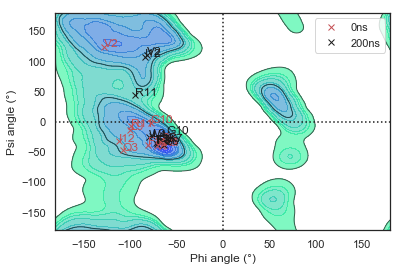

In [11]:
##To do: 
##Reduce function size by not explicitly going through start and end. 

##import everything needed for ramachandran plot
from pylab import *
from matplotlib.colors import LogNorm
from matplotlib import pyplot
import numpy as np 
import glob
import os
import sys
import re


###create contour plot for ramachanrdan 
def plot_rama_base():
    rama_data = np.loadtxt('rama500-general.data')[:,2].reshape(180,180).T
    rama_levels = [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 3, 5, 10, 30, 50, 100, 300]
    contourf(rama_data, levels=rama_levels, cmap=cm.winter_r, norm=LogNorm(0.01, 300), \
            extent=(-180,180,-180,180), alpha=0.5)
    contour(rama_data, levels=[0.01, 0.5], colors='k', norm=LogNorm(0.01, 300), \
            extent=(-180,180,-180,180), linewidths=1, alpha=0.7)
    axhline(y=0, color='k', linestyle=':')
    axvline(x=0, color='k', linestyle=':')


def rama_plot(peptide):
    degree_sign= u'\N{DEGREE SIGN}'
    #Load in data
    df_phi = pd.DataFrame(peptide['phi_time'][0])
    df_psi = pd.DataFrame(peptide['psi_time'][0])
    #### The below (not yet) functions are required to average for the rama plot over the last 20ns
    ##create rama for last 20ns
    phi_end=[]
    psi_end=[]
    for i in range (0,(peptide['resnum']-2)):
        phi_end.append(df_phi[(end-20):end].apply(Dihedral_angles.circularAverage,
                                                  dihedral="phi",mean="no",rama="yes")[i][0])
        psi_end.append(df_psi[(end-20):end].apply(Dihedral_angles.circularAverage,
                                                  dihedral="psi",mean="no",rama="yes")[i][0])
    Rama_End = pd.DataFrame(np.column_stack((phi_end,psi_end,peptide['Aminos'][1:-1])))
    Rama_End.rename(columns={ Rama_End.columns[0]: "Phi",Rama_End.columns[1]: 
                               "Psi",Rama_End.columns[2]: "Residue" }, inplace = True)
    Rama_End= Rama_End[['Phi','Psi']].astype(float)
    ##create rama for first 20ns
    phi_start=[]
    psi_start=[]
    for i in range (0,(peptide['resnum']-2)):
        phi_start.append(df_phi[0:1].apply(Dihedral_angles.circularAverage,
                                          dihedral="phi",mean="no",rama="yes")[i][0])
        psi_start.append(df_psi[0:1].apply(Dihedral_angles.circularAverage,
                                          dihedral="psi",mean="no",rama="yes")[i][0])
    Rama_start = pd.DataFrame(np.column_stack((phi_start,psi_start,peptide['Aminos'][1:-1])))
    Rama_start.rename(columns={ Rama_start.columns[0]: "Phi",Rama_start.columns[1]: 
                               "Psi",Rama_start.columns[2]: "Residue" }, inplace = True)
    Rama_start= Rama_start[['Phi','Psi']].astype(float)
    #use base plot function
    plt.figure()
    plot_rama_base()
    #plot scatters for each angle 
    x=Rama_start['Phi'].values
    y=Rama_start['Psi'].values
    x2=Rama_End['Phi'].values
    y2=Rama_End['Psi'].values
    xlabel('Phi angle (%s)' %degree_sign)
    ylabel('Psi angle (%s)' %degree_sign)
    plot(x,y, linestyle='none', marker='x', color ='r', label ='%sns'%start)
    plot(x2,y2, linestyle='none', marker= 'x', color ='k', label ='%sns'%end)
    legend(loc=0)

    ##label using below sequence
    for i in range(len(x.T)):
        text(x[i], y[i], peptide['sequence'][i+1] + str(i+2), clip_on=True, color='r')   
    for i in range(len(x.T)):
        text(x2[i], y2[i], peptide['sequence'][i+1] + str(i+2), clip_on=True, color='k')
    ##save figure 
    plt.savefig('Rama_average_%s.png'%peptide['peptide_name'],dpi=300,bbox_inches="tight")
        ###create ramachaandran data 
rama_plot(peptide)    

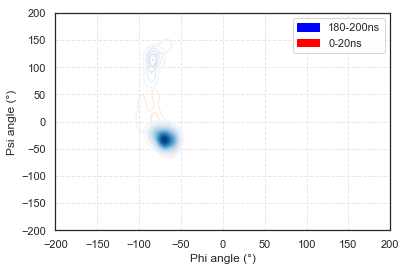

In [12]:
####Take data frame from average dihedralangle plot and slice out start and end
def contour_plot(peptide,start,end):
    #Load in variables
    degree_sign= u'\N{DEGREE SIGN}'
    #Create dataframes
    df_phi = pd.DataFrame(peptide['phi_time'][0])
    df_psi = pd.DataFrame(peptide['psi_time'][0])
    #Take slices
    #phi
    Phi_start_slice = df_phi[start:start+20]
    Phi_start = Phi_start_slice.melt(value_name="Phi",var_name="Residue")
    Phi_end_slice = df_phi[(end-20):end]
    Phi_end = Phi_end_slice.melt(value_name="Phi",var_name="Residue")
    ##Psi
    Psi_start_slice = df_psi[start:(start+20)]
    Psi_start = Psi_start_slice.melt(value_name="Psi",var_name="Residue")
    Psi_end_slice = df_psi[(end-20):end]
    Psi_end = Psi_end_slice.melt(value_name="Psi",var_name="Residue")
    #Remove residue column - Could this be chained onto an earlier command to reduce lines?
    Phi_start.drop('Residue',1,inplace=True)
    Psi_end.drop('Residue',1,inplace=True)
    #combine phi and i
    start = pd.concat([Phi_start, Psi_start], axis=1)
    end = pd.concat([Phi_end, Psi_end], axis=1)

    import matplotlib.patches as mpatches


    ## make contour plot with start and end dihedral angles
    plt.figure()
    ##plot contours 
    #Create two contour plots on the same axis. Levels are arbitary, could be changed. 
    ax = sns.kdeplot(start['Phi'],start['Psi'],
                     cmap="Reds", n_levels=20, )
    ax = sns.kdeplot(end['Phi'],end['Psi'],
                    cmap="Blues", n_levels=20,)
    #modify appearance
    ax.set_axisbelow(True)
    ax.grid(b=True, which='both', color='0.9', linestyle='--')
    #Create legend
    blue_patch = mpatches.Patch(color='Red', label='0-20ns' )
    red_patch = mpatches.Patch(color='Blue', label='180-200ns' )
    plt.legend(handles=[red_patch,blue_patch])
    #aset limits 180 will miss contour, although of course anges can't go higher than this
    plt.xlim(-200,200)
    plt.ylim(-200,200)
    plt.xlabel('Phi angle (%s)' %degree_sign)
    plt.ylabel('Psi angle (%s)' %degree_sign)
    #plot
    plt.savefig('Rama_contour_%s.png'%peptide['peptide_name'],dpi=300,bbox_inches="tight")

contour_plot(peptide,start,end)  